# Concrete Mix Strength Classification Analysis

This notebook analyzes the relationships between concrete mix compositions and their strength classifications, focusing specifically on mixes with 28-day strength results and exploring clustering based on composition.

## Setup and Database Connection

import the necessary libraries and set up the Django environment to access database.

In [1]:
# Add this at the very beginning of your notebook
import os
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"

# Then your existing imports and setup
import sys
import django
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import plotly.express as px
import plotly.graph_objects as go

# Set plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

# Set up Django environment
os.environ.setdefault('DJANGO_SETTINGS_MODULE', 'concrete_mix_project.settings')
sys.path.append('c:/Users/anil_/Documents/concrete_mix_project')
django.setup()

# Import Django models
from cdb_app.models import ConcreteMix, MixComponent, PerformanceResult, MaterialClass
from django.db import models  # Add this for Q objects

## Data Extraction

Now we'll extract mixes with 28-day strength test results from the database.

In [3]:
def get_mixes_with_strength_tests(days=28):
    """Get all mixes with strength test results for a specific age"""
    # Create separate querysets for each category
    compressive_results = PerformanceResult.objects.filter(
        age_days=days, 
        category__icontains='compressive'
    )
    strength_results = PerformanceResult.objects.filter(
        age_days=days, 
        category__icontains='strength'
    )
    hardened_results = PerformanceResult.objects.filter(
        age_days=days, 
        category__icontains='hardened'
    )
    
    # Get unique mix IDs from each queryset
    compressive_mix_ids = set(compressive_results.values_list('mix_id', flat=True))
    strength_mix_ids = set(strength_results.values_list('mix_id', flat=True))
    hardened_mix_ids = set(hardened_results.values_list('mix_id', flat=True))
    
    # Combine the sets
    all_mix_ids = compressive_mix_ids.union(strength_mix_ids, hardened_mix_ids)
    
    # Get the mixes
    mixes = ConcreteMix.objects.filter(pk__in=all_mix_ids)
    
    # Combine results querysets without using union() for later use
    all_results = PerformanceResult.objects.filter(
        age_days=days,
        mix_id__in=all_mix_ids
    ).filter(
        models.Q(category__icontains='compressive') | 
        models.Q(category__icontains='strength') | 
        models.Q(category__icontains='hardened')
    )
    
    print(f"Found {mixes.count()} mixes with {days}-day strength test results")
    return mixes, all_results

In [4]:
# Get mix components by material type
def get_mix_components(mix_id):
    """Get components for a mix, organized by material type"""
    components = MixComponent.objects.filter(mix_id=mix_id)
    result = {}
    
    for comp in components:
        material_class = comp.material.material_class.class_code if comp.material.material_class else 'OTHER'
        if material_class not in result:
            result[material_class] = 0
        result[material_class] += comp.dosage_kg_m3 or 0
    
    return result

# Get mixes with 28-day strength test results
mixes_28d, strength_results_28d = get_mixes_with_strength_tests(days=28)

# Try to also get mixes with other test days if 28-day results are limited
if mixes_28d.count() < 10:
    print("Limited 28-day test results found. Checking other test ages...")
    # Try common test ages
    for age in [7, 56, 90, 180]:
        mixes_alt, strength_results_alt = get_mixes_with_strength_tests(days=age)
        if mixes_alt.count() > mixes_28d.count():
            print(f"Found more {age}-day results than 28-day results. Consider using {age}-day results instead.")

Found 4190 mixes with 28-day strength test results


## Data Processing

Now we'll create a pandas DataFrame from our database data for analysis.

In [6]:
def create_mix_dataframe(mixes, strength_results):
    """Create a DataFrame with mix data and strength results"""
    data = []
    
    for mix in mixes:
        # Get strength result for this mix
        # Use pk instead of id (Django's generic primary key accessor)
        mix_strength = strength_results.filter(mix_id=mix.pk).order_by('-value_num').first()
        
        if not mix_strength:
            continue
            
        # Get components by material type
        components = get_mix_components(mix.pk)
        
        # Create base record
        record = {
            'mix_id': mix.mix_id,
            'dataset': mix.dataset.dataset_name if mix.dataset else 'Unknown',
            'region': mix.region_country or 'Unknown',
            'w_c_ratio': mix.w_c_ratio,
            'w_b_ratio': mix.w_b_ratio,
            'strength': mix_strength.value_num,
            'strength_unit': mix_strength.unit.unit_symbol if mix_strength.unit else 'MPa',
            'test_age': mix_strength.age_days
        }
        
        # Add component data
        for material_class, amount in components.items():
            record[f'{material_class}_kg_m3'] = amount
            
        data.append(record)
    
    # Convert to DataFrame
    df = pd.DataFrame(data)
    
    # Fill missing material amounts with 0
    material_columns = [col for col in df.columns if col.endswith('_kg_m3')]
    for col in material_columns:
        if col not in df.columns:
            df[col] = 0
        else:
            df[col].fillna(0, inplace=True)
    
    # Fill missing ratio values
    df['w_c_ratio'].fillna(0, inplace=True)
    df['w_b_ratio'].fillna(0, inplace=True)
    
    return df

In [8]:
# Create DataFrame for 28-day results
df_28d = create_mix_dataframe(mixes_28d, strength_results_28d)

# Display basic information
print(f"DataFrame created with {len(df_28d)} mixes")
df_28d.head()

DataFrame created with 4190 mixes


C:\Users\anil_\AppData\Local\Temp\ipykernel_10956\4276175007.py:43: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(0, inplace=True)
C:\Users\anil_\AppData\Local\Temp\ipykernel_10956\4276175007.py:46: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doin

,mix_id,dataset,region,w_c_ratio,w_b_ratio,strength,strength_unit,test_age,CEMENT_kg_m3,WATER_kg_m3,SCM_kg_m3,AGGR_C_kg_m3,AGGR_F_kg_m3,ADM_kg_m3
0,7387,DS2,Unknown,0.285,0,102.48,MPa,28,380,108.300,0,0,0,0
1,23230,DS6,Unknown,0,0.45,55.8,MPa,28,400,180.00,0,1092,0,0
2,7388,DS2,Unknown,0.285,0,104.28,MPa,28,380,108.300,0,0,0,0
3,23231,DS6,Unknown,0,0.45,42,MPa,28,400,180.00,0,1075,0,0
4,7389,DS2,Unknown,0.285,0,104.8,MPa,28,380,108.300,0,0,0,0


In [9]:
# Basic statistics for strength values
df_28d['strength'].describe()

count     4190
unique    2488
top         41
freq        16
Name: strength, dtype: object

## Data Visualization

Now let's visualize the strength distribution and relationships with mix components.

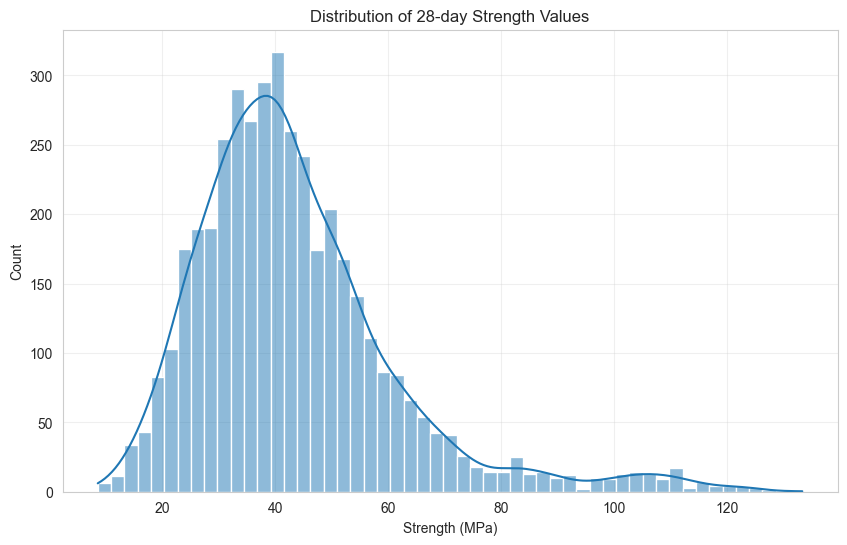

In [10]:
# Plot strength distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_28d['strength'], kde=True)
plt.title('Distribution of 28-day Strength Values')
plt.xlabel('Strength (MPa)')
plt.ylabel('Count')
plt.grid(True, alpha=0.3)
plt.show()

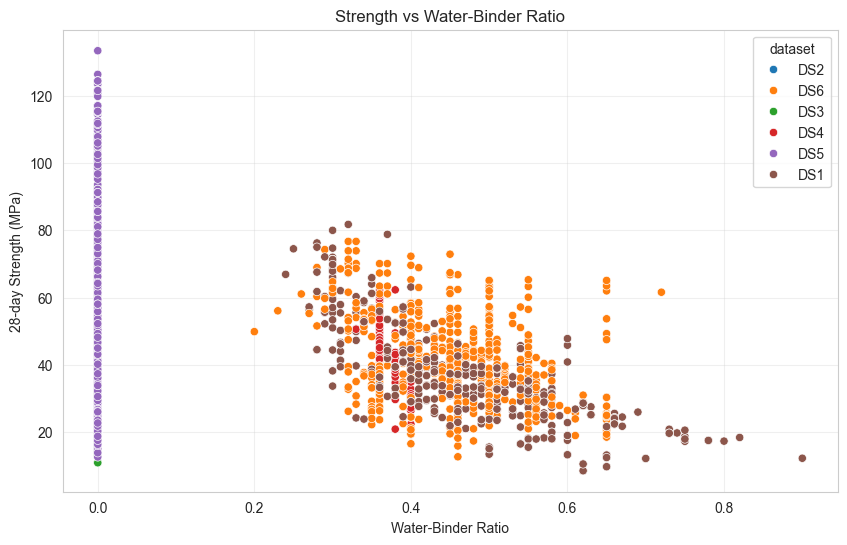

UFuncTypeError: Cannot cast ufunc 'svd_s' input from dtype('O') to dtype('float64') with casting rule 'same_kind'

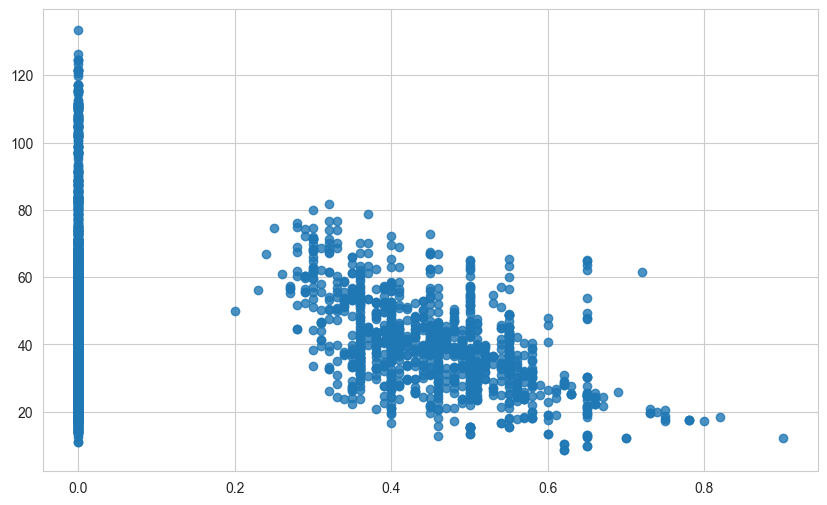

In [12]:
# Analyze relationship between strength and w/b ratio
plt.figure(figsize=(10, 6))
sns.scatterplot(x='w_b_ratio', y='strength', data=df_28d, hue='dataset')
plt.title('Strength vs Water-Binder Ratio')
plt.xlabel('Water-Binder Ratio')
plt.ylabel('28-day Strength (MPa)')
plt.grid(True, alpha=0.3)
plt.show()

# Show regression line
plt.figure(figsize=(10, 6))
sns.regplot(x='w_b_ratio', y='strength', data=df_28d)
plt.title('Regression: Strength vs Water-Binder Ratio')
plt.xlabel('Water-Binder Ratio')
plt.ylabel('28-day Strength (MPa)')
plt.grid(True, alpha=0.3)
plt.show()

# Calculate correlation
corr_wb = df_28d[['strength', 'w_b_ratio']].corr().iloc[0, 1]
print(f"Correlation between strength and w/b ratio: {corr_wb:.3f}")

In [ ]:
# Analyze relationship between strength and material compositions
material_cols = [col for col in df_28d.columns if col.endswith('_kg_m3')]

for col in material_cols[:3]:  # Limit to first 3 materials to avoid too many plots
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=col, y='strength', data=df_28d, hue='dataset')
    material_name = col.replace('_kg_m3', '')
    plt.title(f'Strength vs {material_name} Content')
    plt.xlabel(f'{material_name} (kg/m³)')
    plt.ylabel('28-day Strength (MPa)')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Calculate correlation
    corr = df_28d[['strength', col]].corr().iloc[0, 1]
    print(f"Correlation between strength and {material_name}: {corr:.3f}")

## Correlation Analysis
Let's analyze the correlations between strength and all mix components.

In [ ]:
# Calculate correlations between strength and all material components
correlation_cols = ['strength', 'w_c_ratio', 'w_b_ratio'] + material_cols
corr_matrix = df_28d[correlation_cols].corr()

# Plot correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Strength and Mix Components')
plt.tight_layout()
plt.show()

## Clustering Analysis
Now let's perform clustering to identify groups of similar mixes based on their composition.

In [ ]:
def prepare_data_for_clustering(df):
    """Prepare feature matrix for clustering"""
    # Select features (material compositions and ratios)
    feature_cols = [col for col in df.columns if col.endswith('_kg_m3') or col in ['w_c_ratio', 'w_b_ratio']]
    X = df[feature_cols].copy()
    
    # Handle missing values
    X.fillna(0, inplace=True)
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    return X, X_scaled, feature_cols

# Prepare data for clustering
X, X_scaled, feature_cols = prepare_data_for_clustering(df_28d)
print(f"Prepared {X.shape[1]} features for clustering")

In [ ]:
# Determine optimal number of clusters using elbow method
inertia = []
K_range = range(2, min(10, len(X_scaled)))
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia, 'o-')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# Based on the elbow curve, choose an appropriate number of clusters
# (You can change this after seeing the elbow curve)
n_clusters = 4

# Perform K-means clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Add cluster labels to dataframe
df_clustered = df_28d.copy()
df_clustered['cluster'] = clusters

# Look at the composition of clusters
cluster_counts = df_clustered['cluster'].value_counts().sort_index()
print("Cluster sizes:")
for cluster, count in cluster_counts.items():
    print(f"  Cluster {cluster}: {count} mixes")

# Calculate cluster statistics
cluster_stats = df_clustered.groupby('cluster')['strength'].agg(['mean', 'std', 'min', 'max'])
print("
Strength statistics by cluster:")
print(cluster_stats)

In [ ]:
# Visualize clusters in 2D using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create scatter plot of clusters
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', s=50, alpha=0.8)
centers = kmeans.cluster_centers_
centers_pca = pca.transform(centers)
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], c='red', s=200, alpha=0.8, marker='X')
plt.title('PCA Projection of Concrete Mix Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter, label='Cluster')
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# Create an interactive plot with Plotly
df_plot = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'Cluster': clusters.astype(str),
    'Mix ID': df_28d['mix_id'],
    'Strength': df_28d['strength'],
    'W/C Ratio': df_28d['w_c_ratio']
})

fig = px.scatter(df_plot, x='PC1', y='PC2', color='Cluster', 
                hover_data=['Mix ID', 'Strength', 'W/C Ratio'],
                title='Interactive Cluster Visualization')
fig.show()

## Cluster Analysis
Let's analyze the characteristics of each cluster.

In [ ]:
# Analyze clusters in terms of strength
plt.figure(figsize=(10, 6))
sns.boxplot(x='cluster', y='strength', data=df_clustered)
plt.title('Strength Distribution by Cluster')
plt.xlabel('Cluster')
plt.ylabel('28-day Strength (MPa)')
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# Show feature importances for each cluster
importances = kmeans.cluster_centers_
cluster_importances = pd.DataFrame(importances, columns=feature_cols)

plt.figure(figsize=(14, 8))
sns.heatmap(cluster_importances, annot=True, cmap='YlGnBu')
plt.title('Feature Importance by Cluster')
plt.tight_layout()
plt.show()

In [ ]:
# Analyze the composition of each cluster
for cluster in sorted(df_clustered['cluster'].unique()):
    cluster_df = df_clustered[df_clustered['cluster'] == cluster]
    print(f"
Cluster {cluster} ({len(cluster_df)} mixes):")
    print(f"Average strength: {cluster_df['strength'].mean():.2f} MPa")
    print(f"W/C ratio range: {cluster_df['w_c_ratio'].min():.2f} - {cluster_df['w_c_ratio'].max():.2f}")
    
    # Print top 3 most common materials in this cluster
    material_cols = [col for col in df_clustered.columns if col.endswith('_kg_m3')]
    avg_materials = cluster_df[material_cols].mean().sort_values(ascending=False)
    print("Top materials (avg kg/m³):")
    for mat, amount in avg_materials.head(3).items():
        if amount > 0:
            print(f"  {mat.replace('_kg_m3', '')}: {amount:.1f}")

## Save Results
Let's save the clustered data for future reference.

In [ ]:
# Save results to CSV
df_clustered.to_csv('../analysis/strength_classification_results.csv', index=False)
print("Results saved to 'strength_classification_results.csv'")

## Conclusion

This analysis has identified distinct clusters of concrete mixes based on their composition and correlated these clusters with strength characteristics. These insights can help in developing better mix designs by understanding which component combinations lead to desired strength properties.

Some key findings:

1. The relationship between w/c ratio and strength follows the expected inverse correlation
2. Certain materials show stronger correlations with strength than others
3. The identified clusters represent distinct concrete mix 'families' with characteristic strength ranges

For future work, we could:

1. Extend this analysis to include durability properties
2. Create predictive models for strength based on mix composition
3. Develop optimization algorithms for mix design based on target properties